In [98]:
import sys
import numpy as np
from fmm import fmm1d_te
from matplotlib import pyplot as plt
from fmm import fmm1d_te_layer_modes
from scipy.fftpack import ifft

### Task 1

In [ ]:
plt.rcParams.update({
        'figure.figsize': (12/2.54, 9/2.54),
        'figure.subplot.bottom': 0.145,
        'figure.subplot.left': 0.165,
        'figure.subplot.right': 0.9,
        'figure.subplot.top': 0.9,
        'figure.subplot.wspace': 0.35,
        'figure.subplot.hspace': 0.3,
        'axes.grid': False,
        'image.cmap': 'viridis',
})

plt.close('all')
np.set_printoptions(threshold=sys.maxsize)

In [249]:
# %% parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
lam       = 1.064  # vacuum wavelength [µm]
period    = 3.0    # period of the grating [µm]
width     = 1.5    # width of the high index region [µm]
perm_l    = 1.0    # permittivity of the low index regions of the grating
perm_h    = 4.0    # permittivity of the high index regions of the grating
kx        = 0.0    # Bloch vector
Nx        = 1001   # number of points to discretize the permittivity
                   # ditribution
N         = 25     # number of Fourier orders

k0 = 2*np.pi/lam   # vacuum wavenumber

# create permittivity array centred on x = 0
perm = np.ones((Nx))
perm[0:Nx//4] = perm_l
perm[Nx//4:3*Nx//4] = perm_h
perm[3*Nx//4:] = perm_l


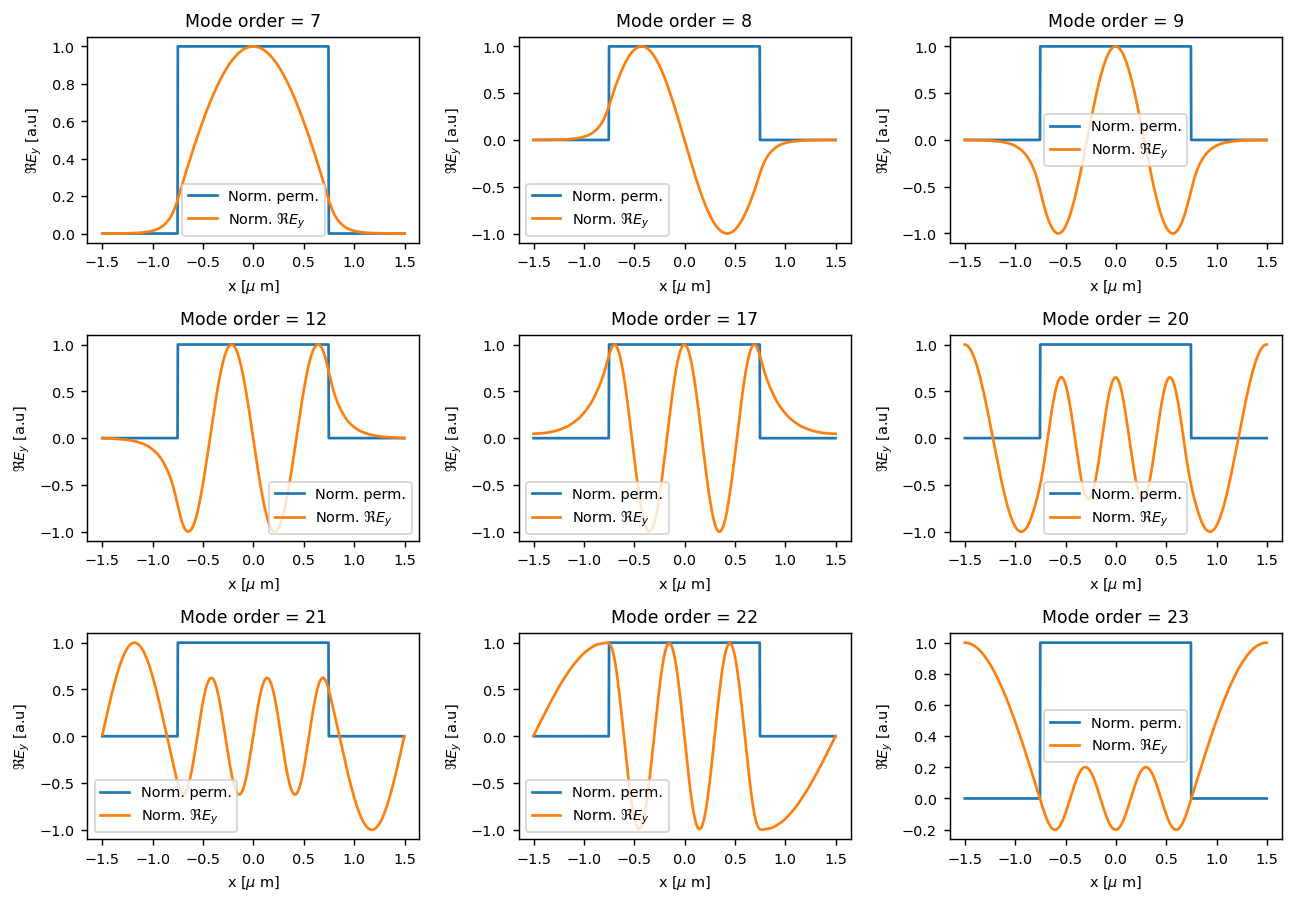

In [251]:
#solving for modes and prop. constants
beta, eigmodes = fmm1d_te_layer_modes(perm, period, k0, kx, N)

#selecting forward propagating modes
orders = np.arange(-N,N+1)
orders = orders[prop_sort]
prop_sort = np.where(np.abs(beta.imag) < np.abs(1e-10*beta.real))[0]
beta = np.real(beta[prop_sort])
eigmodes = eigmodes[:,prop_sort]

#Re-padding field fourier components and taking the inverse FT
Ey = np.zeros((beta.size,Nx),dtype=complex)
x = period/Nx*np.arange(Nx) - 1.5
for i in range(beta.size):
    Ey[i,:N+1] = eigmodes[N:2*N+1,i].flatten()
    Ey[i,-N:] = eigmodes[:N,i].flatten()
    Ey[i,:] = ifft(Ey[i,:])

#Plotting 
normp = (perm - np.min(perm))/(np.max(perm - np.min(perm)))
plt.rc('font',size=8)
f, ax = plt.subplots(3,3,dpi=130,figsize=(10,7))
axs = ax.flatten()
for i in range(beta.size):
    axs[i].plot(x,normp,label='Norm. perm.')
    axs[i].plot(x,Ey[i].real/np.max(Ey[i].real),label=r'Norm. $\Re{E_y}$')
    axs[i].legend()
    axs[i].set_title('Mode order = {:.0f}'.format(orders[i]))
    axs[i].set_xlabel(r'x [$\mu$ m]')
    axs[i].set_ylabel(r'$\Re{E_y}$ [a.u]')
    
f.tight_layout()
plt.show()

f.savefig('spatial_profile.png',bbox_inches='tight',dpi=200)

## Task 2

In [235]:

# %% parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
lam         = 1.064  # vacuum wavelength [µm]
period      = 3.0    # period of the grating [µm]
widths      = np.array([1, 2, 3])/4.0*period  # widths of the high index
                                              # regions [µm]
thicknesses = np.array([1, 1, 1])*0.25  # thicknesses of the
                                        # grating layers [µm]
perm_l      = 1.0   # permittivity of the low index regions of the grating
perm_h      = 4.0   # permittivity of the high index regions of the grating
perm_in     = 1.0   # permittivity on the incidence side
perm_out    = 4.0   # permittivity on the exit side
Nx          = 1001  # number of points to discretize the permittivity
                    # ditribution
N           = 20    # number of positive Fourier orders

x = np.arange(Nx) * period / Nx
layer_perm = perm_l * np.ones((len(widths), Nx))

for i in range(len(widths)):
    layer_perm[i, x <= widths[i]] = perm_h

#solving for test parameters
orders = np.arange(-N,N+1)    
theta_list = np.deg2rad([-30,0,30])
eta_r = np.array([])
eta_t = np.array([])

for theta in theta_list:
    th_eta_r, th_eta_t, r, t = fmm1d_te(lam, theta, period, perm_in, perm_out,layer_perm, thicknesses, N)
    eta_r = np.append(eta_r,th_eta_r)
    eta_t = np.append(eta_t,th_eta_t)
    
eta_r = eta_r.reshape((theta_list.size,-1))
eta_t = eta_t.reshape((theta_list.size,-1))
theta_list = np.rad2deg(theta_list)


In [236]:
#Exporting tables
import pandas as pd
dfr = pd.DataFrame(eta_r[:,20-10:20+11]*100,columns=orders[20-10:20+11])
dft = pd.DataFrame(eta_t[:,20-10:20+11]*100,columns=orders[20-10:20+11])
dfthe = pd.DataFrame({'theta':theta_list})
dfr = dfthe.join(dfr)
dft = dfthe.join(dft)

print(dfr.to_latex(index=False,float_format="%.2f"))
print(dft.to_latex(index=False,float_format="%.2f"))



\begin{tabular}{rrrrrrrrrrrrrrrrrrrrrr}
\toprule
 theta &  -10 &   -9 &   -8 &   -7 &   -6 &   -5 &   -4 &   -3 &   -2 &   -1 &    0 &    1 &    2 &    3 &    4 &    5 &    6 &    7 &    8 &    9 &   10 \\
\midrule
-30.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.87 & 0.82 & 2.86 & 3.65 & 0.01 & 0.05 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
  0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 2.29 & 0.34 & 0.67 & 1.49 & 2.39 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
 30.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 1.05 & 3.39 & 1.83 & 0.47 & 0.82 & 4.15 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}

\begin{tabular}{rrrrrrrrrrrrrrrrrrrrrr}
\toprule
 theta &  -10 &   -9 &   -8 &   -7 &   -6 &   -5 &   -4 &   -3 &   -2 &    -1 &    0 &    1 &    2 &     3 &    4 &    5 &    6 &    7 &    8 &    9 &   10 \\
\midrule
-30.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 3.56 & 0.30 & 1.76 

In [237]:
#Extending analysis to +/-90 degrees
orders = np.arange(-N,N+1)    
theta_list = np.deg2rad(np.linspace(-89.99,89.99,300))
eta_r = np.array([])
eta_t = np.array([])

for theta in theta_list:
    th_eta_r, th_eta_t, r, t = fmm1d_te(lam, theta, period, perm_in, perm_out,layer_perm, thicknesses, N)
    eta_r = np.append(eta_r,th_eta_r)
    eta_t = np.append(eta_t,th_eta_t)
    
eta_r = eta_r.reshape((theta_list.size,-1))
eta_t = eta_t.reshape((theta_list.size,-1))

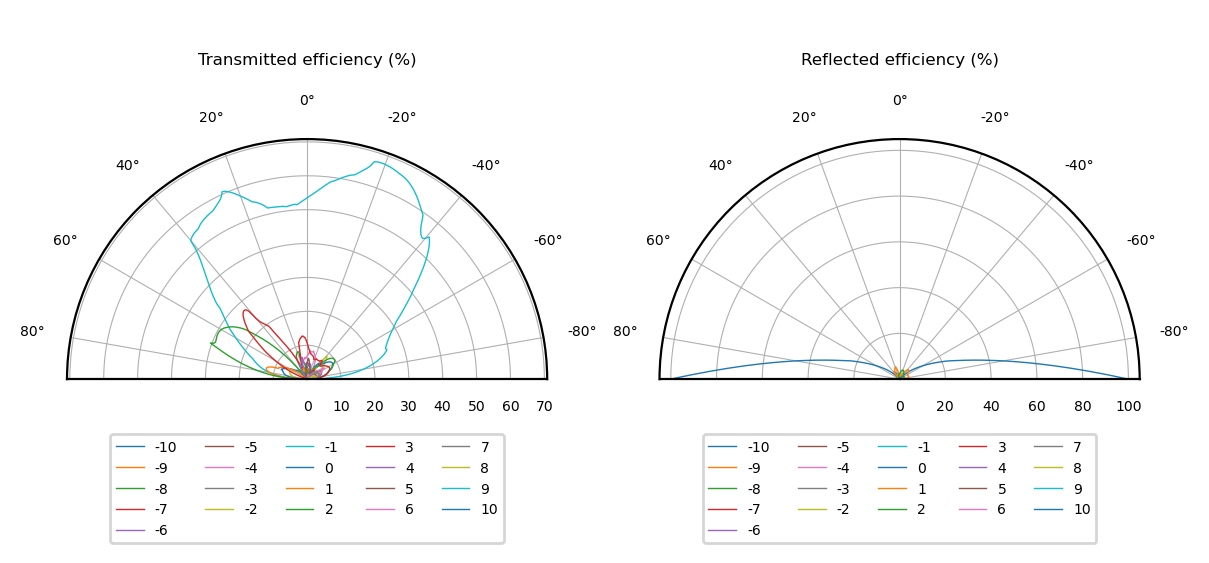

In [239]:
plt.rc('font',size=5)
f1 = plt.figure(dpi=200)
ax1 = f1.add_subplot(121,polar=True)
for N in np.where(np.abs(orders)<=10)[0]:
    ax1.plot(theta_list,eta_t[:,N].flatten()*100,lw=0.5,label='{}'.format(orders[N]))

ax1.set_thetamin(-90)
ax1.set_thetamax(90)
ax1.grid(lw=0.4)
ax1.legend(loc='upper center',ncol=5,bbox_to_anchor=(0.5,0.15))
ax1.set_theta_zero_location("N")
ax1.set_title('Transmitted efficiency (%)',loc='center',pad=-25)

ax2 = f1.add_subplot(122,polar=True)
for N in np.where(np.abs(orders)<=10)[0]:
    ax2.plot(theta_list,eta_r[:,N].flatten()*100,lw=0.5,label='{}'.format(orders[N]))

ax2.set_thetamin(-90)
ax2.set_thetamax(90)
ax2.grid(lw=0.4)
ax2.legend(loc='upper center',ncol=5,bbox_to_anchor=(0.5,0.15))
ax2.set_theta_zero_location("N")
ax2.set_title('Reflected efficiency (%)',loc='center',pad=-25)
f1.tight_layout()
plt.show()
f1.savefig('efficiencies_plot.png',bbox_inches='tight',dpi=200)

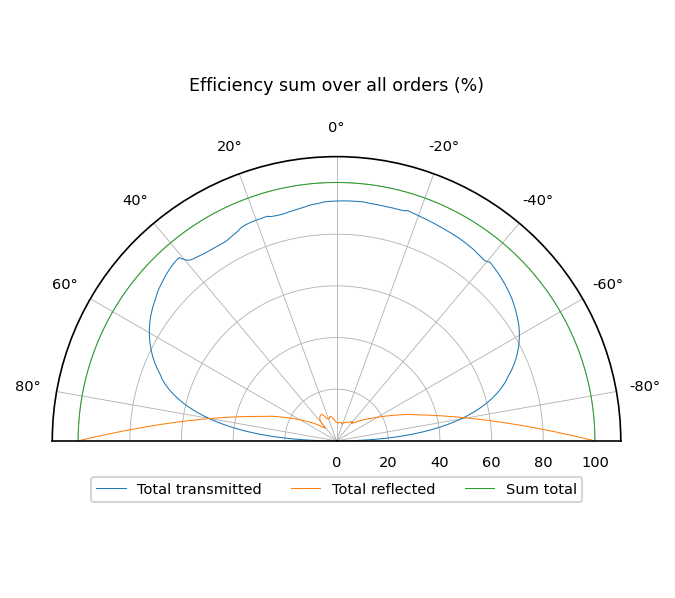

In [241]:
plt.rc('font',size=7)
f3 = plt.figure(dpi=150)
ax1 = f3.add_subplot(111,polar=True)

ax1.plot(theta_list,np.sum(eta_t,axis=1).flatten()*100,lw=0.5,label=r'Total transmitted')
ax1.plot(theta_list,np.sum(eta_r,axis=1).flatten()*100,lw=0.5,label='Total reflected')
ax1.plot(theta_list,(np.sum(eta_t,axis=1).flatten()+np.sum(eta_r,axis=1).flatten())*100,lw=0.5,label='Sum total')

ax1.set_thetamin(-90)
ax1.set_thetamax(90)
ax1.grid(lw=0.4)
ax1.legend(loc='upper center',ncol=5,bbox_to_anchor=(0.5,0.20))
ax1.set_theta_zero_location("N")
ax1.set_title('Efficiency sum over all orders (%)',loc='center',pad=-50)
ax1.set_rlim([0,110])

f3.tight_layout()
plt.show()
f3.savefig('sum_efficiencies_plot.png',bbox_inches='tight',dpi=200)

## Side questions

In [242]:
# %% parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
lam         = 1.064  # vacuum wavelength [µm]
period      = 3.0    # period of the grating [µm]
widths      = np.array([1, 2, 3])/4.0*period  # widths of the high index
                                              # regions [µm]
thicknesses = np.array([1, 1, 1])*0.25  # thicknesses of the
                                        # grating layers [µm]
perm_l      = 1.0   # permittivity of the low index regions of the grating
perm_h      = 4.0   # permittivity of the high index regions of the grating
perm_in     = 1.0   # permittivity on the incidence side
perm_out    = 4.0   # permittivity on the exit side
Nx          = 1001  # number of points to discretize the permittivity
                    # ditribution
N           = 40    # number of positive Fourier orders

x = np.arange(Nx) * period / Nx
layer_perm = perm_l * np.ones((len(widths), Nx))

for i in range(len(widths)):
    layer_perm[i, x <= widths[i]] = perm_h

orders = np.arange(-N,N+1)    
theta_list = np.deg2rad(np.linspace(-89.99,89.99,300))
eta_r = np.array([])
eta_t = np.array([])

for theta in theta_list:
    th_eta_r, th_eta_t, r, t = fmm1d_te(lam, theta, period, perm_in, perm_out,layer_perm, thicknesses, N)
    eta_r = np.append(eta_r,th_eta_r)
    eta_t = np.append(eta_t,th_eta_t)
    
eta_r = eta_r.reshape((theta_list.size,-1))
eta_t = eta_t.reshape((theta_list.size,-1))

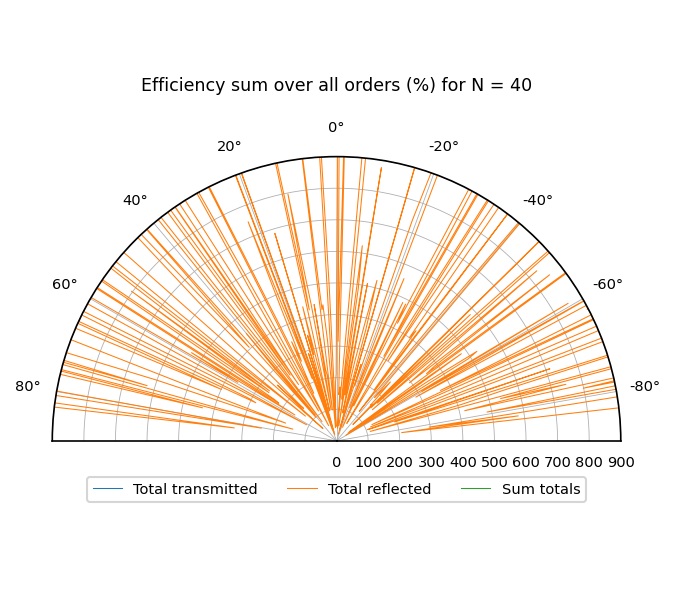

In [243]:
plt.rc('font',size=7)
f3 = plt.figure(dpi=150)
ax1 = f3.add_subplot(111,polar=True)

ax1.plot(theta_list,np.sum(eta_t,axis=1).flatten()*100,lw=0.5,label=r'Total transmitted')
ax1.plot(theta_list,np.sum(eta_r,axis=1).flatten()*100,lw=0.5,label='Total reflected')
ax1.plot(theta_list,(np.sum(eta_t,axis=1).flatten()+np.sum(eta_r,axis=1).flatten())*100,lw=0.5,label='Sum totals')

ax1.set_thetamin(-90)
ax1.set_thetamax(90)
ax1.grid(lw=0.4)
ax1.legend(loc='upper center',ncol=5,bbox_to_anchor=(0.5,0.20))
ax1.set_theta_zero_location("N")
ax1.set_title('Efficiency sum over all orders (%) for N = 40',loc='center',pad=-50)
ax1.set_rlim([0,900])

f3.tight_layout()
plt.show()
f3.savefig('sum_effic_N40.png',bbox_inches='tight',dpi=200)

In [244]:
# %% parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
lam         = 1.064  # vacuum wavelength [µm]
period      = 3.0    # period of the grating [µm]
widths      = np.array([1, 2, 3])/4.0*period  # widths of the high index
                                              # regions [µm]
thicknesses = np.array([1, 1, 1])*0.5  # thicknesses of the
                                        # grating layers [µm]
perm_l      = 1.0   # permittivity of the low index regions of the grating
perm_h      = 4.0   # permittivity of the high index regions of the grating
perm_in     = 1.0   # permittivity on the incidence side
perm_out    = 4.0   # permittivity on the exit side
Nx          = 1001  # number of points to discretize the permittivity
                    # ditribution
N           = 20    # number of positive Fourier orders

x = np.arange(Nx) * period / Nx
layer_perm = perm_l * np.ones((len(widths), Nx))

for i in range(len(widths)):
    layer_perm[i, x <= widths[i]] = perm_h

orders = np.arange(-N,N+1)    
theta_list = np.deg2rad(np.linspace(-89.99,89.99,300))
eta_r = np.array([])
eta_t = np.array([])

for theta in theta_list:
    th_eta_r, th_eta_t, r, t = fmm1d_te(lam, theta, period, perm_in, perm_out,layer_perm, thicknesses, N)
    eta_r = np.append(eta_r,th_eta_r)
    eta_t = np.append(eta_t,th_eta_t)
    
eta_r = eta_r.reshape((theta_list.size,-1))
eta_t = eta_t.reshape((theta_list.size,-1))

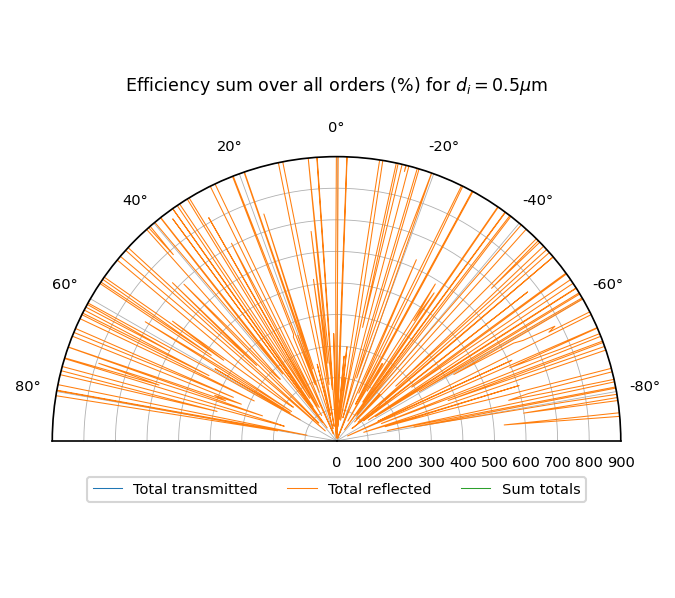

In [246]:
plt.rc('font',size=7)
f3 = plt.figure(dpi=150)
ax1 = f3.add_subplot(111,polar=True)

ax1.plot(theta_list,np.sum(eta_t,axis=1).flatten()*100,lw=0.5,label=r'Total transmitted')
ax1.plot(theta_list,np.sum(eta_r,axis=1).flatten()*100,lw=0.5,label='Total reflected')
ax1.plot(theta_list,(np.sum(eta_t,axis=1).flatten()+np.sum(eta_r,axis=1).flatten())*100,lw=0.5,label='Sum totals')

ax1.set_thetamin(-90)
ax1.set_thetamax(90)
ax1.grid(lw=0.4)
ax1.legend(loc='upper center',ncol=5,bbox_to_anchor=(0.5,0.20))
ax1.set_theta_zero_location("N")
ax1.set_title(r'Efficiency sum over all orders (%) for $d_i = 0.5\mu$m',loc='center',pad=-50)
ax1.set_rlim([0,900])

f3.tight_layout()
plt.show()
f3.savefig('sum_effic_d05.png',bbox_inches='tight',dpi=200)